In [ ]:
#!pip install scikit-learn-extra
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from kmodes.kprototypes import KPrototypes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score , calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import collections
from kmodes.kmodes import KModes
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering

In [ ]:
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/Tesis2/df_final.csv', na_values=' ')
df.rename(columns = {'round': 'ronda'}, inplace = True)
df = df.dropna(axis=1, how='all')
#df = df.drop(['rawscre', 'ppvt_raw', 'maths_raw','sppvt_raw',	'srawscre',	'score_cog',	'rscorelang_cog',	'rscorelang_ppvt',	'score_ppvt'], axis = 1)

df = df[df.panel12345==1]
df.head()




Mounted at /content/gdrive


,childid,yc,ronda,inround,panel12345,deceased,dint,placeid,clustid,typesite,...,hospital,maths_raw,ppvt_raw,rawscre,sppvt_raw,srawscre,score_cog,rscorelang_cog,rscorelang_ppvt,score_ppvt
0,PE011001,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PE011001,1,2,1,1,NaN,3/26/2007,PE01C01,1.000,1.000,...,NaN,NaN,NaN,22.000,NaN,NaN,9.000,305.212,280.317,22.000
2,PE011001,1,3,1,1,NaN,8/10/2009,PE01C01,1.000,1.000,...,NaN,21.000,80.000,80.000,NaN,NaN,NaN,NaN,NaN,NaN
3,PE011001,1,4,1,1,NaN,8/8/2013,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PE011001,1,5,1,1,NaN,8/11/2016,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sns.set(rc={'figure.figsize':(15,6)})
sns.set_style("white")

In [ ]:
for i in [1,2,3,4,5]:
  df.loc[df.ronda == i, 'pobreza'] = pd.qcut(df.loc[df.ronda == i, 'wi'], 3, labels=False)


## Exploracion

Text(0.5, 1.0, 'Indice de Nivel Socioeconomico')

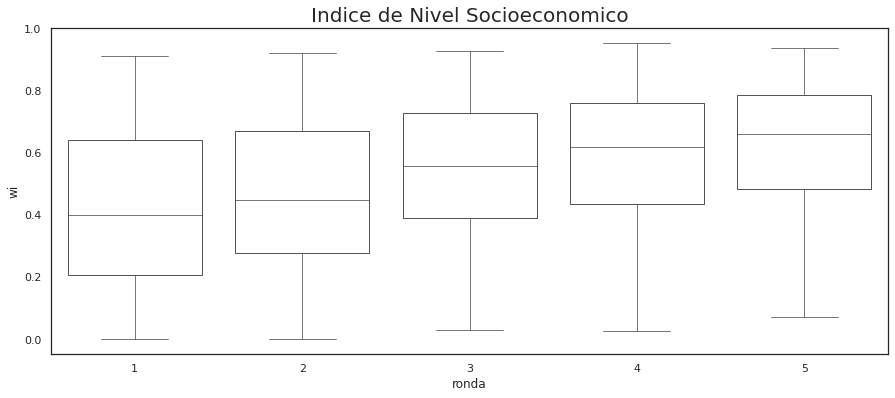

In [ ]:
ax=sns.boxplot(data = df[df['wi']>0], x='ronda', y='wi',showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("Indice de Nivel Socioeconomico", fontsize = 20)

In [ ]:
df1 = df.loc[(df.ronda== 5)&(df.pobreza == 2),['childid','pobreza']]
df2 = pd.merge(df1, df.loc[(df.ronda==1),['childid','pobreza']],how='left',on='childid')
df2.groupby(['pobreza_x','pobreza_y'])['childid'].count()/df2.shape[0]

pobreza_x  pobreza_y
2.000      0.000       0.072
           1.000       0.262
           2.000       0.664
Name: childid, dtype: float64

In [ ]:
df1 = df.loc[(df.ronda== 1)&(df.pobreza == 0),['childid','pobreza']]
df2 = pd.merge(df1, df.loc[(df.ronda==5),['childid','pobreza']],how='left',on='childid')
df2.groupby(['pobreza_x','pobreza_y'])['childid'].count()/df2.shape[0]

pobreza_x  pobreza_y
0.000      0.000       0.658
           1.000       0.256
           2.000       0.071
Name: childid, dtype: float64

Text(0.5, 1.0, 'Retraso en el Crecimiento')

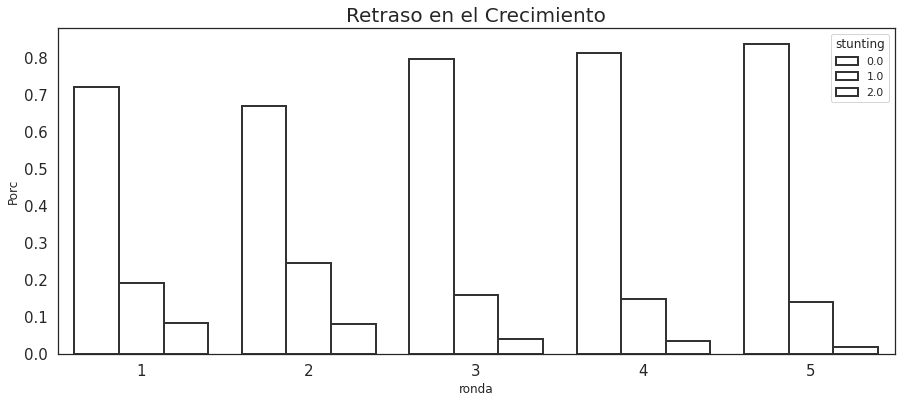

In [ ]:
crosstab = df.groupby(['ronda'])['stunting'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'Porc').reset_index()
ax = sns.barplot(x="ronda", hue="stunting",y='Porc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Retraso en el Crecimiento", fontsize = 20)

Text(0.5, 1.0, 'Retraso en el Crecimiento - Segun Nivel Socioeconomico')

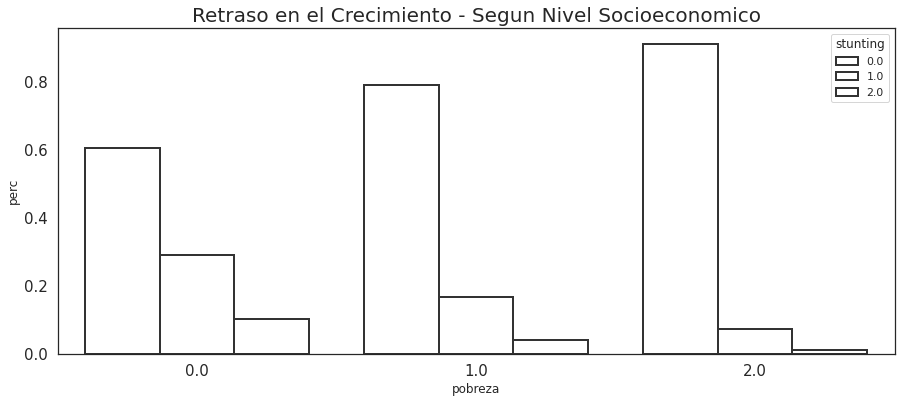

In [ ]:
crosstab = df.groupby(['pobreza'])['stunting'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="stunting",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Retraso en el Crecimiento - Segun Nivel Socioeconomico", fontsize = 20)

Text(0.5, 1.0, 'Ronda 1: Retraso en el Crecimiento - Segun Nivel Socioeconomico')

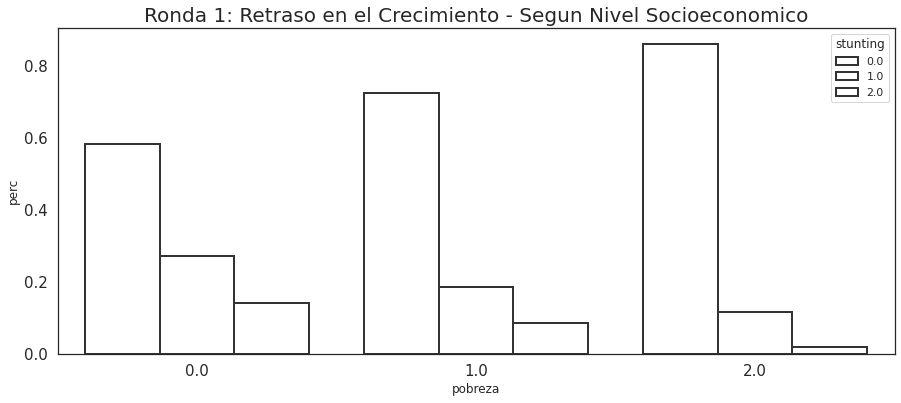

In [ ]:
crosstab = df.loc[df.ronda==1].groupby(['pobreza'])['stunting'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="stunting",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Ronda 1: Retraso en el Crecimiento - Segun Nivel Socioeconomico", fontsize = 20)

Text(0.5, 1.0, 'Ronda 5: Retraso en el Crecimiento - Segun Nivel Socioeconomico')

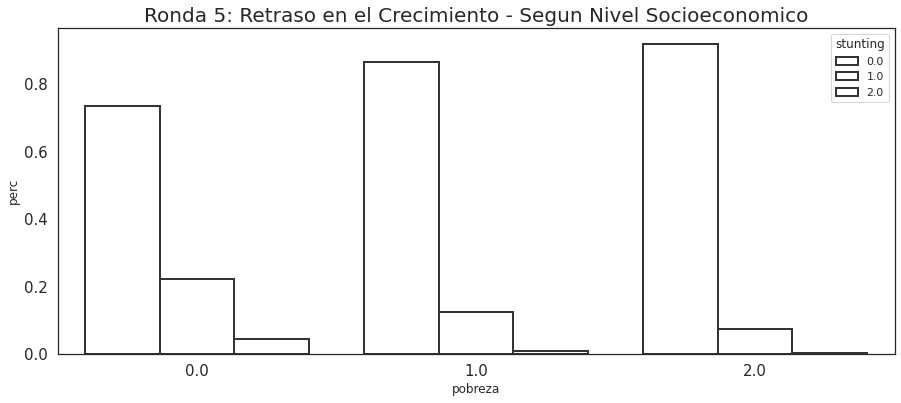

In [ ]:
crosstab = df.loc[df.ronda==5].groupby(['pobreza'])['stunting'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="stunting",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Ronda 5: Retraso en el Crecimiento - Segun Nivel Socioeconomico", fontsize = 20)

Text(0.5, 1.0, 'Indice de Masa Cordporal - Segun Ronda y Nivel Socioeconomico')

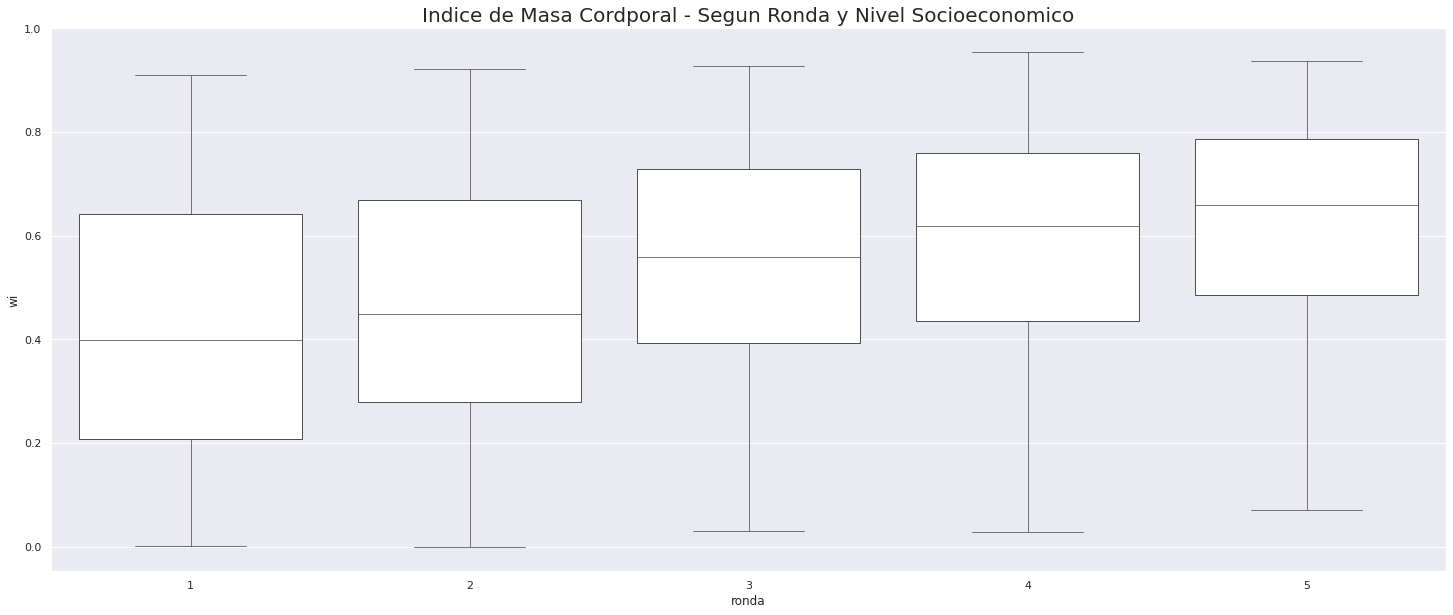

In [ ]:
ax=sns.boxplot(data = df[df['wi']>0], y='wi', x = 'ronda', showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("Indice de Masa Cordporal - Segun Ronda y Nivel Socioeconomico", fontsize = 20)

Text(0.5, 1.0, 'Indice de Masa Cordporal - Segun Ronda y Nivel Socioeconomico')

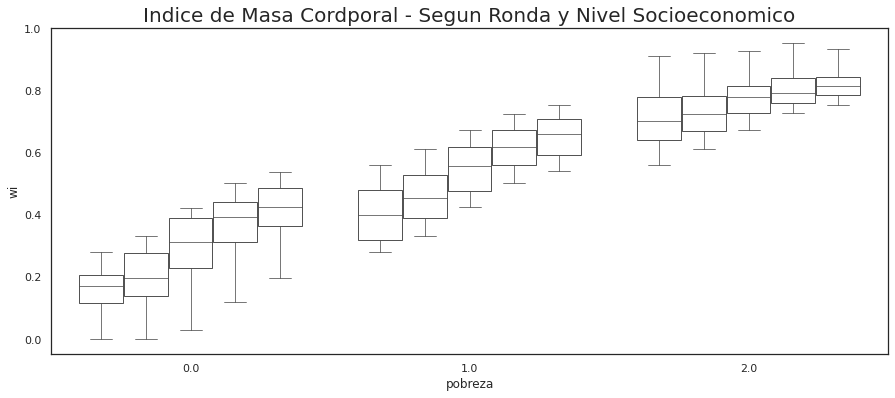

In [ ]:
ax=sns.boxplot(data = df[df['wi']>0], x='pobreza', y='wi', hue = 'ronda', showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("Indice de Masa Cordporal - Segun Ronda y Nivel Socioeconomico", fontsize = 20)

Text(0.5, 1.0, 'chmightdie')

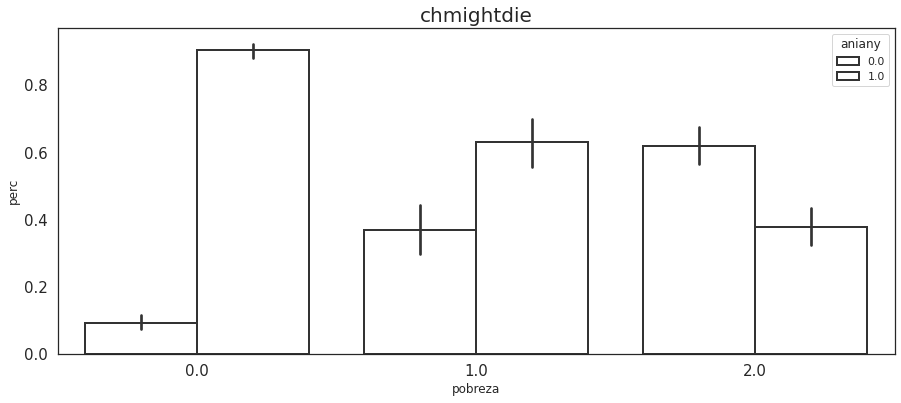

In [ ]:
crosstab = df.groupby(['ronda','pobreza'])['aniany'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="aniany",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("chmightdie", fontsize = 20)

Text(0.5, 1.0, 'credit')

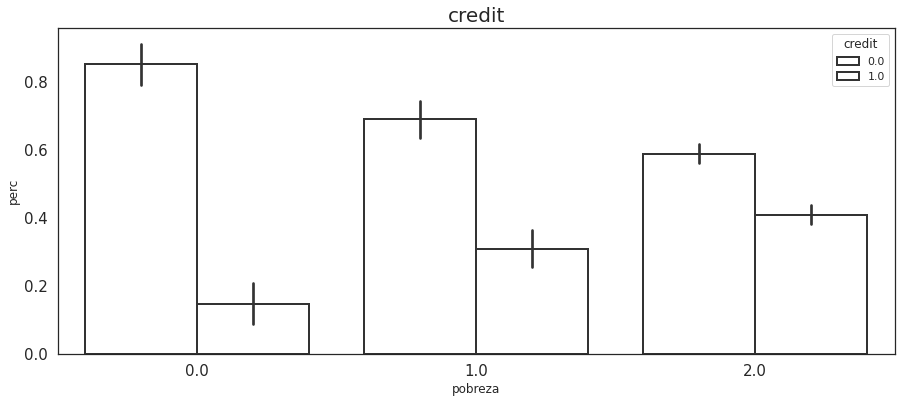

In [ ]:
crosstab = df.groupby(['ronda','pobreza'])['credit'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="credit",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("credit", fontsize = 20)

Text(0.5, 1.0, 'foodsec')

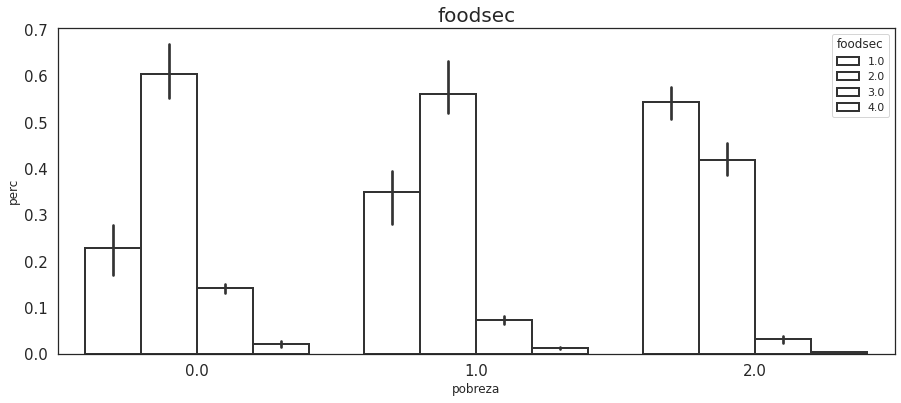

In [ ]:
crosstab = df.groupby(['ronda','pobreza'])['foodsec'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="foodsec",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("foodsec", fontsize = 20)

Text(0.5, 1.0, 'juntos')

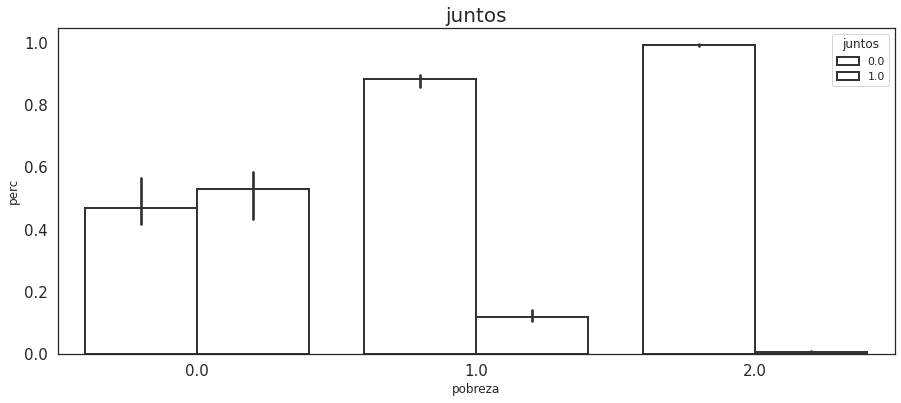

In [ ]:
crosstab = df.groupby(['ronda','pobreza'])['juntos'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="juntos",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("juntos", fontsize = 20)

## Escuela

In [ ]:
'''drive.mount('/content/gdrive')
rendimiento_cognitivo_r5 = pd.read_csv('gdrive/My Drive/Tesis2/pe_r5_yccogtest_youngerchild.csv', na_values=' ')
rendimiento_cognitivo_r4 = pd.read_csv('gdrive/My Drive/Tesis2/pe_r4_yccog_youngerchild.csv', na_values=' ')
rendimiento_cognitivo_r3 = pd.read_csv('gdrive/My Drive/Tesis2/pe_yc_childlevel.csv', na_values=' ')
print(rendimiento_cognitivo_r5.shape)

rendimiento_cognitivo_r5 = rendimiento_cognitivo_r5.dropna(axis=1, how='all')
rendimiento_cognitivo_r4 = rendimiento_cognitivo_r4.dropna(axis=1, how='all')
rendimiento_cognitivo_r3 = rendimiento_cognitivo_r3.dropna(axis=1, how='all')

rendimiento_cognitivo_r5['ronda'] = 5
rendimiento_cognitivo_r4['ronda'] = 4
rendimiento_cognitivo_r3['ronda'] = 3

rendimiento_cognitivo_r5['childid'] = 'PE' + rendimiento_cognitivo_r5.CHILDCODE.astype(int).astype(str)
rendimiento_cognitivo_r4['childid'] = 'PE' + rendimiento_cognitivo_r4.CHILDCODE.astype(int).astype(str)
rendimiento_cognitivo_r3.rename(columns = {'CHILDID': 'childid','ppvt': 'ppvt_raw','math':'maths_raw'}, inplace = True)'''


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(1860, 277)


In [ ]:
'''
rcog5 = rendimiento_cognitivo_r5.loc[:,['RAWSCRE', 'STDSCRE', 'ppvt_raw', 'maths_raw', 'reading_raw', 'childid','ronda']]
rcog4 = rendimiento_cognitivo_r4.loc[:,['RAWSCRE', 'STDSCRE', 'ppvt_raw', 'maths_raw', 'lang_raw', 'childid','ronda']]
rcog3 = rendimiento_cognitivo_r3.loc[:,['RAWSCRE', 'STDSCRE', 'ppvt_raw', 'maths_raw', 'childid','ronda']]

cogtest = pd.concat([rcog5,rcog4,rcog3],axis = 0)
cogtest.groupby('ronda').agg({'childid':['count'],
                              'RAWSCRE':['count','mean'], 
                              'STDSCRE':['count','mean'], 
                              'ppvt_raw':['count','mean'], 
                              'maths_raw':['count','mean'], 
                              'reading_raw':['count','mean']})

rendimiento_cognitivo_r3.childid.nunique()'''

1943

In [ ]:
df2 = pd.merge(df, cogtest, on=['childid','ronda'],how = 'left')
df2.groupby('ronda').agg({'childid':['count'],
                              'RAWSCRE':['count','mean'], 
                              'STDSCRE':['count','mean'], 
                              'ppvt_raw':['count','mean'], 
                              'maths_raw':['count','mean'], 
                              'reading_raw':['count','mean']})

childid RAWSCRE        STDSCRE        ppvt_raw        maths_raw         \
        count   count   mean   count   mean    count   mean     count   mean   
ronda                                                                          
1        1807       0    NaN       0    NaN        0    NaN         0    NaN   
2        1807       0    NaN       0    NaN        0    NaN         0    NaN   
3        1807    1773 59.336    1774 95.670     1714 59.043      1755 14.228   
4        1807     960 84.594     960 97.023      950 86.401       946 15.993   
5        1807     958 93.341     958 93.402      940 96.747       962 11.256   

      reading_raw         
            count   mean  
ronda                     
1               0    NaN  
2               0    NaN  
3               0    NaN  
4               0    NaN  
5             933 16.884

Text(0.5, 1.0, 'Nivel Primario Completo')

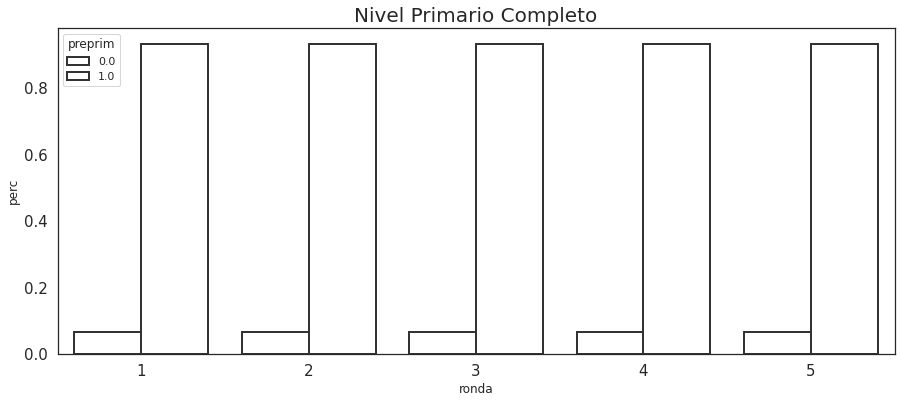

In [ ]:
crosstab = df.groupby(['ronda'])['preprim'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="ronda", hue="preprim",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Nivel Primario Completo", fontsize = 20)

Text(0.5, 1.0, 'Nivel Primario Completo - Nivel Socioeconomico')

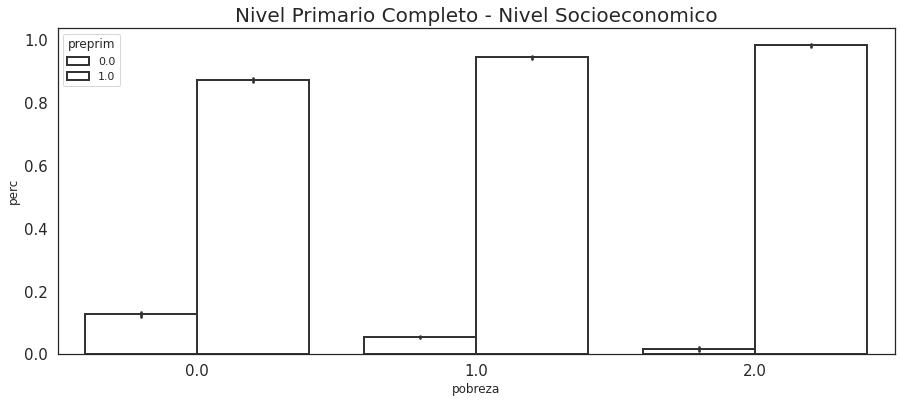

In [ ]:
crosstab = df.groupby(['ronda','pobreza'])['preprim'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="preprim",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Nivel Primario Completo - Nivel Socioeconomico", fontsize = 20)

Text(0.5, 1.0, 'Alfabetismo')

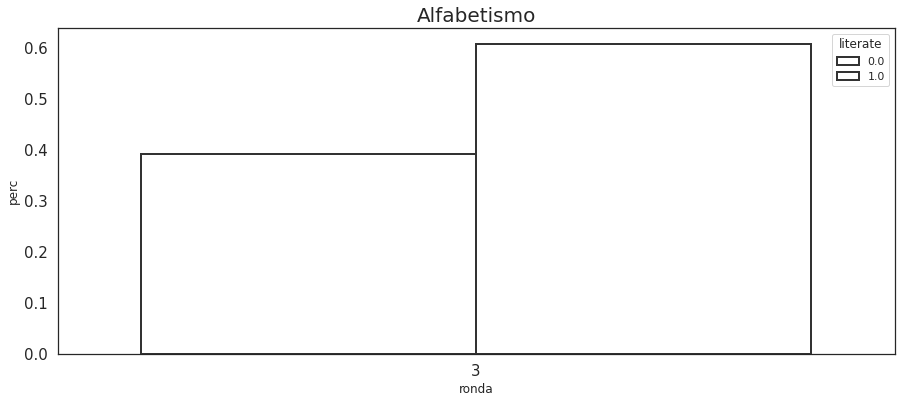

In [ ]:
crosstab = df.groupby(['ronda'])['literate'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="ronda", hue="literate",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Alfabetismo", fontsize = 20)

Text(0.5, 1.0, 'Alfabetismo - Segun Nivel Socioeconomico')

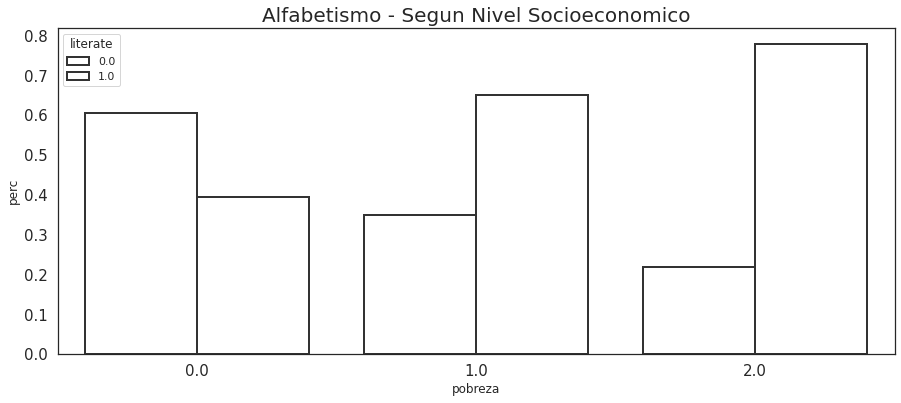

In [ ]:
crosstab = df.groupby(['ronda','pobreza'])['literate'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="literate",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Alfabetismo - Segun Nivel Socioeconomico", fontsize = 20)

Text(0.5, 1.0, 'levlwrit')

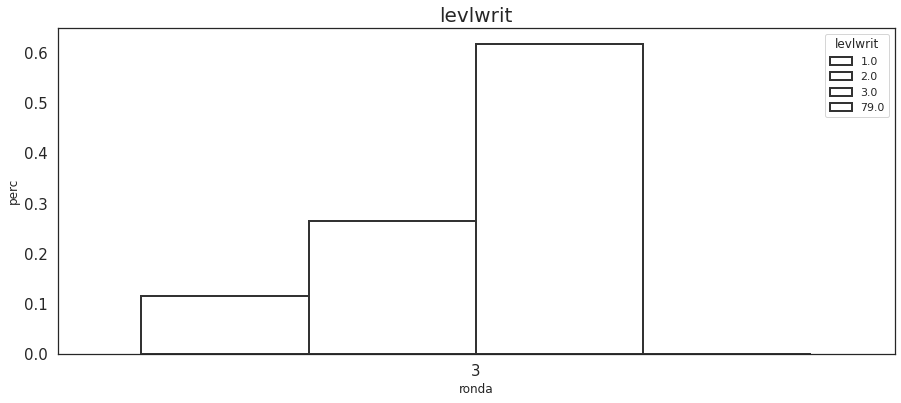

In [ ]:
crosstab = df.groupby(['ronda'])['levlwrit'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="ronda", hue="levlwrit",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("levlwrit", fontsize = 20)

Text(0.5, 1.0, 'levlwrit')

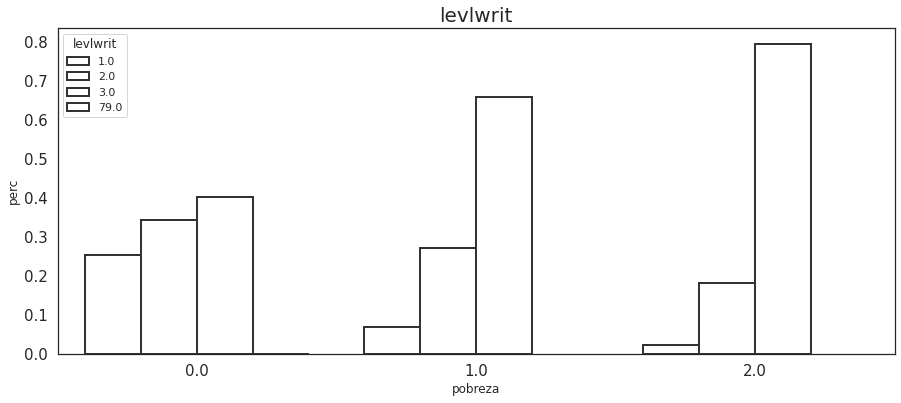

In [ ]:
crosstab = df.groupby(['ronda','pobreza'])['levlwrit'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="pobreza", hue="levlwrit",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("levlwrit", fontsize = 20)

Text(0.5, 1.0, 'maths_raw')

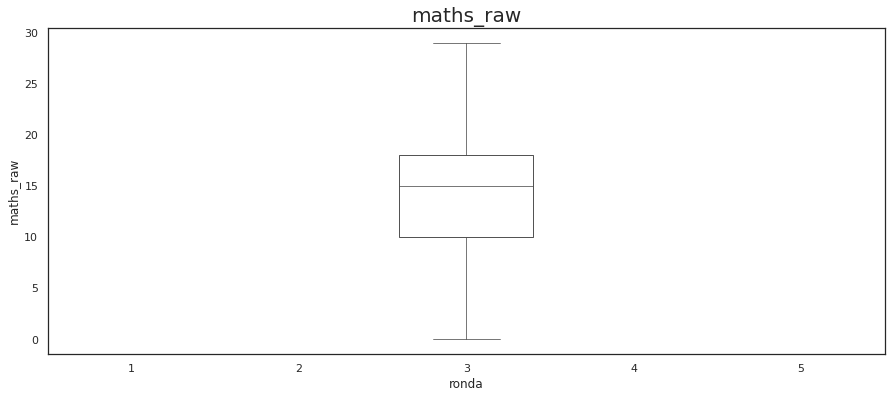

In [ ]:
ax=sns.boxplot(data = df, x='ronda', y='maths_raw', showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("maths_raw", fontsize = 20)

Text(0.5, 1.0, 'maths_raw')

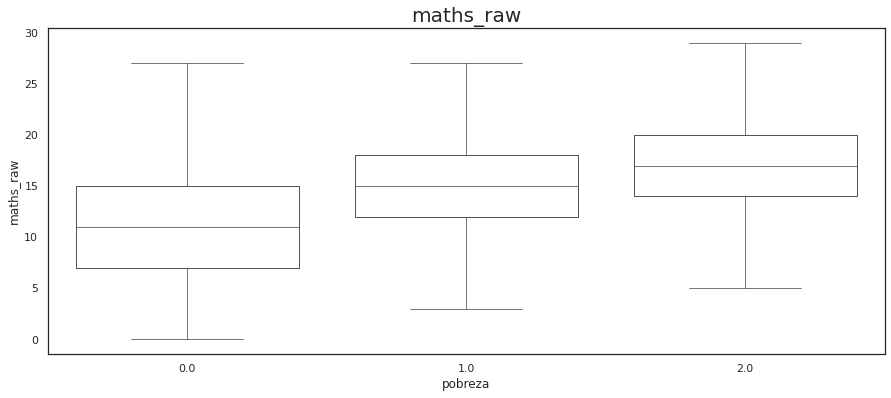

In [ ]:
ax=sns.boxplot(data = df, x='pobreza', y='maths_raw' , showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("maths_raw", fontsize = 20)

## Kmeans

In [ ]:
df.hospital.replace(['Yes', 'No'],[0,1], inplace=True)
df.loc[:, df.dtypes == object].head()

rondas = [1,2,3,4,5]

admin_feat = ['childid',"ronda","yc","panel12345",'dint',"placeid",'clustid','inround']
data_final = df.loc[:,['childid',"yc"]].drop_duplicates().sort_values(by = 'childid')

print('number of kids', data_final.shape)
print('number of columns',(df.shape[1]-3)*5+3)

for i in rondas:
  data_ronda = pd.DataFrame()
  data_ronda = df[df.ronda == i].sort_values(by = 'childid')
  columns = [j+'_'+str(i) if j not in admin_feat else j for j in data_ronda.columns]
  
  data_ronda.columns = columns
  data_ronda.drop(["yc","panel12345",'dint',"placeid",'clustid','inround'], axis=1, inplace=True)
  data_final = pd.merge(data_final,data_ronda, how = 'left', on = ['childid'])
  
data_final.shape

number of kids (1807, 2)
number of columns 1088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ronda_x'} in the result is deprecated and will raise a MergeError in a future version.


(1807, 1067)

In [ ]:
data_final=data_final.dropna(axis=1, how='all')
data_final.shape

(1807, 762)

In [ ]:
data_final.head()

,childid,yc,ronda_x,typesite_1,region_1,childloc_1,chsex_1,chlang_1,chethnic_1,chldrel_1,...,shfam3_5,shfam4_5,shfam5_5,shfam6_5,shfam7_5,shfam8_5,shfam9_5,shfam18_5,shother_5,pobreza_5
0,PE011001,1,1,1.000,31.000,1.000,2,31.000,32,5,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
1,PE011002,1,1,1.000,31.000,1.000,2,31.000,32,5,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,PE011003,1,1,1.000,31.000,1.000,1,31.000,32,5,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
3,PE011004,1,1,1.000,31.000,1.000,1,31.000,32,5,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000
4,PE011005,1,1,1.000,31.000,1.000,1,31.000,32,5,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000


### Features


In [ ]:
#categorical_features = ['headrel_1','carerel_1','carehead_1','entype_1','chrephealth4_1','chdisscale_1','region_1','headrel_2','carerel_2','carehead_2','entype_2','chrephealth4_2','chdisscale_2','region_2','headrel_3','carerel_3','carehead_3','entype_3','chrephealth4_3','chdisscale_3','region_3','headrel_4','carerel_4','carehead_4','entype_4','chrephealth4_4','chdisscale_4','region_4','headrel_5','carerel_5','carehead_5','entype_5','chrephealth4_5','chdisscale_5','region_5']
#dummy_features = ['agegr1_1','bcg_1','beca_yl_1','birth_1','bonograt_1','bwdoc_1','carecantread_1','credit_1','chrephealth3_1','chrephealth2_1','chrephealth1_1','delivery_1','dpt_1','dadcantread_1','dadedu_1','caredu_1','dadlive_1','engrade_1','enrol_1','foodsec_1','headedudu_1','headsex_1','hib_1','insur_yl_1','juntos_1','marrcohab_1','measles_1','minsa_yl_1','momcantread_1','momedu_1','momlive_1','numante_1','ownhouse_1','ownlandhse_1','polio_1','preprim_1','projoven_yl_1','shcrime1_1','shcrime2_1','shcrime3_1','shcrime4_1','shcrime5_1','shcrime6_1','shcrime8_1','shecon1_1','shecon10_1','shecon11_1','shecon12_1','shecon14_1','shecon2_1','shecon3_1','shecon4_1','shecon5_1','shecon6_1','shecon7_1','shecon8_1','shecon9_1','shenv1_1','shenv10_1','shenv11_1','shenv12_1','shenv2_1','shenv3_1','shenv4_1','shenv5_1','shenv6_1','shenv7_1','shenv8_1','shenv9_1','shfam1_1','shfam10_1','shfam12_1','shfam13_1','shfam14_1','shfam15_1','shfam16_1','shfam17_1','shfam18_1','shfam2_1','shfam3_1','shfam4_1','shfam5_1','shfam6_1','shfam7_1','shfam8_1','shfam9_1','shhouse1_1','shhouse2_1','shhouse3_1','shother_1','shregul1_1','shregul2_1','shregul4_1','shregul5_1','shregul6_1','tetanus_1','typesite_1','sisgrat_yl_1','agegr1_2','bcg_2','beca_yl_2','birth_2','bonograt_2','bwdoc_2','carecantread_2','credit_2','chrephealth3_2','chrephealth2_2','chrephealth1_2','delivery_2','dpt_2','dadcantread_2','dadedu_2','caredu_2','dadlive_2','engrade_2','enrol_2','foodsec_2','headedudu_2','headsex_2','hib_2','insur_yl_2','juntos_2','marrcohab_2','measles_2','minsa_yl_2','momcantread_2','momedu_2','momlive_2','numante_2','ownhouse_2','ownlandhse_2','polio_2','preprim_2','projoven_yl_2','shcrime1_2','shcrime2_2','shcrime3_2','shcrime4_2','shcrime5_2','shcrime6_2','shcrime8_2','shecon1_2','shecon10_2','shecon11_2','shecon12_2','shecon14_2','shecon2_2','shecon3_2','shecon4_2','shecon5_2','shecon6_2','shecon7_2','shecon8_2','shecon9_2','shenv1_2','shenv10_2','shenv11_2','shenv12_2','shenv2_2','shenv3_2','shenv4_2','shenv5_2','shenv6_2','shenv7_2','shenv8_2','shenv9_2','shfam1_2','shfam10_2','shfam12_2','shfam13_2','shfam14_2','shfam15_2','shfam16_2','shfam17_2','shfam18_2','shfam2_2','shfam3_2','shfam4_2','shfam5_2','shfam6_2','shfam7_2','shfam8_2','shfam9_2','shhouse1_2','shhouse2_2','shhouse3_2','shother_2','shregul1_2','shregul2_2','shregul4_2','shregul5_2','shregul6_2','tetanus_2','typesite_2','sisgrat_yl_2','agegr1_3','bcg_3','beca_yl_3','birth_3','bonograt_3','bwdoc_3','carecantread_3','credit_3','chrephealth3_3','chrephealth2_3','chrephealth1_3','delivery_3','dpt_3','dadcantread_3','dadedu_3','caredu_3','dadlive_3','engrade_3','enrol_3','foodsec_3','headedudu_3','headsex_3','hib_3','insur_yl_3','juntos_3','marrcohab_3','measles_3','minsa_yl_3','momcantread_3','momedu_3','momlive_3','numante_3','ownhouse_3','ownlandhse_3','polio_3','preprim_3','projoven_yl_3','shcrime1_3','shcrime2_3','shcrime3_3','shcrime4_3','shcrime5_3','shcrime6_3','shcrime8_3','shecon1_3','shecon10_3','shecon11_3','shecon12_3','shecon14_3','shecon2_3','shecon3_3','shecon4_3','shecon5_3','shecon6_3','shecon7_3','shecon8_3','shecon9_3','shenv1_3','shenv10_3','shenv11_3','shenv12_3','shenv2_3','shenv3_3','shenv4_3','shenv5_3','shenv6_3','shenv7_3','shenv8_3','shenv9_3','shfam1_3','shfam10_3','shfam12_3','shfam13_3','shfam14_3','shfam15_3','shfam16_3','shfam17_3','shfam18_3','shfam2_3','shfam3_3','shfam4_3','shfam5_3','shfam6_3','shfam7_3','shfam8_3','shfam9_3','shhouse1_3','shhouse2_3','shhouse3_3','shother_3','shregul1_3','shregul2_3','shregul4_3','shregul5_3','shregul6_3','tetanus_3','typesite_3','sisgrat_yl_3','agegr1_4','bcg_4','beca_yl_4','birth_4','bonograt_4','bwdoc_4','carecantread_4','credit_4','chrephealth3_4','chrephealth2_4','chrephealth1_4','delivery_4','dpt_4','dadcantread_4','dadedu_4','caredu_4','dadlive_4','engrade_4','enrol_4','foodsec_4','headedudu_4','headsex_4','hib_4','insur_yl_4','juntos_4','marrcohab_4','measles_4','minsa_yl_4','momcantread_4','momedu_4','momlive_4','numante_4','ownhouse_4','ownlandhse_4','polio_4','preprim_4','projoven_yl_4','shcrime1_4','shcrime2_4','shcrime3_4','shcrime4_4','shcrime5_4','shcrime6_4','shcrime8_4','shecon1_4','shecon10_4','shecon11_4','shecon12_4','shecon14_4','shecon2_4','shecon3_4','shecon4_4','shecon5_4','shecon6_4','shecon7_4','shecon8_4','shecon9_4','shenv1_4','shenv10_4','shenv11_4','shenv12_4','shenv2_4','shenv3_4','shenv4_4','shenv5_4','shenv6_4','shenv7_4','shenv8_4','shenv9_4','shfam1_4','shfam10_4','shfam12_4','shfam13_4','shfam14_4','shfam15_4','shfam16_4','shfam17_4','shfam18_4','shfam2_4','shfam3_4','shfam4_4','shfam5_4','shfam6_4','shfam7_4','shfam8_4','shfam9_4','shhouse1_4','shhouse2_4','shhouse3_4','shother_4','shregul1_4','shregul2_4','shregul4_4','shregul5_4','shregul6_4','tetanus_4','typesite_4','sisgrat_yl_4','agegr1_5','bcg_5','beca_yl_5','birth_5','bonograt_5','bwdoc_5','carecantread_5','credit_5','chrephealth3_5','chrephealth2_5','chrephealth1_5','delivery_5','dpt_5','dadcantread_5','dadedu_5','caredu_5','dadlive_5','engrade_5','enrol_5','foodsec_5','headedudu_5','headsex_5','hib_5','insur_yl_5','juntos_5','marrcohab_5','measles_5','minsa_yl_5','momcantread_5','momedu_5','momlive_5','numante_5','ownhouse_5','ownlandhse_5','polio_5','preprim_5','projoven_yl_5','shcrime1_5','shcrime2_5','shcrime3_5','shcrime4_5','shcrime5_5','shcrime6_5','shcrime8_5','shecon1_5','shecon10_5','shecon11_5','shecon12_5','shecon14_5','shecon2_5','shecon3_5','shecon4_5','shecon5_5','shecon6_5','shecon7_5','shecon8_5','shecon9_5','shenv1_5','shenv10_5','shenv11_5','shenv12_5','shenv2_5','shenv3_5','shenv4_5','shenv5_5','shenv6_5','shenv7_5','shenv8_5','shenv9_5','shfam1_5','shfam10_5','shfam12_5','shfam13_5','shfam14_5','shfam15_5','shfam16_5','shfam17_5','shfam18_5','shfam2_5','shfam3_5','shfam4_5','shfam5_5','shfam6_5','shfam7_5','shfam8_5','shfam9_5','shhouse1_5','shhouse2_5','shhouse3_5','shother_5','shregul1_5','shregul2_5','shregul4_5','shregul5_5','shregul6_5','tetanus_5','typesite_5','sisgrat_yl_5']
#numeric_features = ['aniany_1','anibeeh_1','anicowm_1','anicowt_1','anidonk_1','anidrau_1','anifish_1','anifshr_1','anigoat_1','aniguin_1','anillam_1','animilk_1','aniothr_1','anioxen_1','anipigs_1','anipoul_1','anirabb_1','anirumi_1','anishee_1','anishri_1','anisnai_1','anispec_1','birth_age_1','bwght_1','careage_1','careladder_1','careldr4yrs_1','commsch_1','commwork_1','dadage_1','female05_1','female1317_1','female1860_1','female61_1','female612_1','hcare_1','hchore_1','headage_1','hhsize_1','hplay_1','hschool_1','hsleep_1','hstudy_1','htask_1','hwork_1','inround_1','lang_raw_1','levlread_1','levlwrit_1','literate_1','male05_1','male1317_1','male1860_1','male61_1','male612_1','marrcohab_age_1','maths_raw_1','momage_1','ppvt_raw_1','rawscre_1','reading_raw_1','rscorelang_cog_1','rscorelang_ppvt_1','score_cog_1','score_ppvt_1','sppvt_raw_1','srawscre_1','aniany_2','anibeeh_2','anicowm_2','anicowt_2','anidonk_2','anidrau_2','anifish_2','anifshr_2','anigoat_2','aniguin_2','anillam_2','animilk_2','aniothr_2','anioxen_2','anipigs_2','anipoul_2','anirabb_2','anirumi_2','anishee_2','anishri_2','anisnai_2','anispec_2','birth_age_2','bwght_2','careage_2','careladder_2','careldr4yrs_2','commsch_2','commwork_2','dadage_2','female05_2','female1317_2','female1860_2','female61_2','female612_2','hcare_2','hchore_2','headage_2','hhsize_2','hplay_2','hschool_2','hsleep_2','hstudy_2','htask_2','hwork_2','inround_2','lang_raw_2','levlread_2','levlwrit_2','literate_2','male05_2','male1317_2','male1860_2','male61_2','male612_2','marrcohab_age_2','maths_raw_2','momage_2','ppvt_raw_2','rawscre_2','reading_raw_2','rscorelang_cog_2','rscorelang_ppvt_2','score_cog_2','score_ppvt_2','sppvt_raw_2','srawscre_2','aniany_3','anibeeh_3','anicowm_3','anicowt_3','anidonk_3','anidrau_3','anifish_3','anifshr_3','anigoat_3','aniguin_3','anillam_3','animilk_3','aniothr_3','anioxen_3','anipigs_3','anipoul_3','anirabb_3','anirumi_3','anishee_3','anishri_3','anisnai_3','anispec_3','birth_age_3','bwght_3','careage_3','careladder_3','careldr4yrs_3','commsch_3','commwork_3','dadage_3','female05_3','female1317_3','female1860_3','female61_3','female612_3','hcare_3','hchore_3','headage_3','hhsize_3','hplay_3','hschool_3','hsleep_3','hstudy_3','htask_3','hwork_3','inround_3','lang_raw_3','levlread_3','levlwrit_3','literate_3','male05_3','male1317_3','male1860_3','male61_3','male612_3','marrcohab_age_3','maths_raw_3','momage_3','ppvt_raw_3','rawscre_3','reading_raw_3','rscorelang_cog_3','rscorelang_ppvt_3','score_cog_3','score_ppvt_3','sppvt_raw_3','srawscre_3','aniany_4','anibeeh_4','anicowm_4','anicowt_4','anidonk_4','anidrau_4','anifish_4','anifshr_4','anigoat_4','aniguin_4','anillam_4','animilk_4','aniothr_4','anioxen_4','anipigs_4','anipoul_4','anirabb_4','anirumi_4','anishee_4','anishri_4','anisnai_4','anispec_4','birth_age_4','bwght_4','careage_4','careladder_4','careldr4yrs_4','commsch_4','commwork_4','dadage_4','female05_4','female1317_4','female1860_4','female61_4','female612_4','hcare_4','hchore_4','headage_4','hhsize_4','hplay_4','hschool_4','hsleep_4','hstudy_4','htask_4','hwork_4','inround_4','lang_raw_4','levlread_4','levlwrit_4','literate_4','male05_4','male1317_4','male1860_4','male61_4','male612_4','marrcohab_age_4','maths_raw_4','momage_4','ppvt_raw_4','rawscre_4','reading_raw_4','rscorelang_cog_4','rscorelang_ppvt_4','score_cog_4','score_ppvt_4','sppvt_raw_4','srawscre_4','aniany_5','anibeeh_5','anicowm_5','anicowt_5','anidonk_5','anidrau_5','anifish_5','anifshr_5','anigoat_5','aniguin_5','anillam_5','animilk_5','aniothr_5','anioxen_5','anipigs_5','anipoul_5','anirabb_5','anirumi_5','anishee_5','anishri_5','anisnai_5','anispec_5','birth_age_5','bwght_5','careage_5','careladder_5','careldr4yrs_5','commsch_5','commwork_5','dadage_5','female05_5','female1317_5','female1860_5','female61_5','female612_5','hcare_5','hchore_5','headage_5','hhsize_5','hplay_5','hschool_5','hsleep_5','hstudy_5','htask_5','hwork_5','inround_5','lang_raw_5','levlread_5','levlwrit_5','literate_5','male05_5','male1317_5','male1860_5','male61_5','male612_5','marrcohab_age_5','maths_raw_5','momage_5','ppvt_raw_5','rawscre_5','reading_raw_5','rscorelang_cog_5','rscorelang_ppvt_5','score_cog_5','score_ppvt_5','sppvt_raw_5','srawscre_5']

#categorical_features = [i for i in categorical_features if i in data_final.columns]
#dummy_features = [i for i in dummy_features if i in data_final.columns]
#numeric_features = [i for i in numeric_features if i in data_final.columns]

cat_features = ['region','childloc','chlang','chethnic','chldrel','marrcohab','marrcohab_age','birth','birth_age','fwfl','fhfa','fwfa','fbfa','underweight','stunting','thinness','delivery','tetanus','bcg','measles','polio','dpt','hib','chmightdie','chillness','chinjury','chhprob','chdisability','chrephealth2','chrephealth3','chrephealth4','preprim','enrol','entype','literate','carehead','caresex','carerel','dadlive','dadcantread','dadyrdied','momlive','momyrdied','headsex','headrel','drwaterq','toiletq','elecq','cookingq','aniany','ownlandhse','ownhouse','juntos','bonograt','sisgrat_yl','minsa_yl','insur_yl','beca_yl','projoven_yl','credit','shcrime1','shcrime2','shcrime3','shcrime4','shcrime5','shcrime6','shcrime8','shregul1','shregul2','shregul4','shregul5','shregul6','shecon1','shecon2','shecon3','shecon4','shecon5','shecon6','shecon7','shecon8','shecon9','shecon10','shecon11','shecon12','shecon14','shenv1','shenv2','shenv3','shenv4','shenv5','shenv6','shenv7','shenv8','shenv9','shenv10','shenv11','shenv12','shhouse1','shhouse2','shhouse3','shfam1','shfam2','shfam3','shfam4','shfam5','shfam6','shfam7','shfam8','shfam9','shfam10','shfam12','shfam13','shfam14','shfam15','shfam16','shfam17','shfam18','shother','hospital']
num_features = ['chdisscale','chsmoke','chalcohol','chrephealth1','chhrel','chhealth','cladder','engrade','levlwrit','levlread','caredu','carecantread','careladder','careldr4yrs','dadedu','momedu','momcantread','headedudu','foodsec','agemon','chweight','chheight','bmi','zwfa','zhfa','zbfa','zwfl','bwght','bwdoc','numante','hsleep','hcare','hchore','htask','hwork','hschool','hstudy','hplay','commwork','commsch','agegr1','timesch','careage','dadage','momage','headage','hhsize','male05','male612','male1317','male1860','male61','female05','female612','female1317','female1860','female61','wi','hq','sv','cd','animilk','anidrau','anirumi','anispec','anicowm','anicowt','anioxen','anidonk','anishee','anigoat','anipigs','anipoul','anirabb','anillam','aniguin','anisnai','anibeeh','anifish','anishri','anifshr','aniothr', 'maths_raw', 'ppvt_raw', 'rawscre', 'sppvt_raw', 'srawscre',
       'score_cog', 'rscorelang_cog', 'rscorelang_ppvt', 'score_ppvt']

for r in [1,2,3,4,5]:
  categorical_features = [i+'_'+str(r) for i in cat_features]
  numeric_features = [i+'_'+str(r) for i in num_features]

total_cols = categorical_features+numeric_features
total_cols = [i for i in total_cols if i in data_final.columns]
#total_cols

In [ ]:
data_final.loc[:, data_final.dtypes == object].head()

,childid
0,PE011001
1,PE011002
2,PE011003
3,PE011004
4,PE011005


In [ ]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(data_final.loc[:,total_cols])
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
X = imp_mean.fit_transform(X_scaled)

<function matplotlib.pyplot.show>

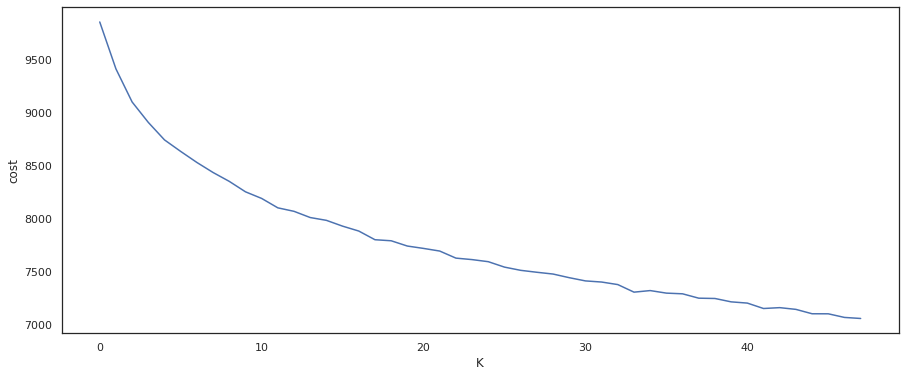

In [ ]:

#utilizo metodo del codo
inertia = []
n_clusters = []
clusters_assigned = []

cost = []
for num_clusters in list(range(2,50)):
  kmeans = KMeans(n_clusters=num_clusters, random_state=42,n_init=10) 
  kmeans.fit_predict(X)
  inertia.append(kmeans.inertia_)

plt.plot(inertia)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init = 30).fit(X)
y_kmeans = kmeans.predict(X)

print('observations per cluster',
      collections.Counter(y_kmeans),'\n')
print('Inertia: Sum of squared distances of samples to their closest cluster center',
      kmeans.inertia_,'\n')
print('calinski-harabaz score',
      calinski_harabasz_score(X, y_kmeans),'\n')
print('silhouette score',
      silhouette_score(X, y_kmeans),'\n')
'''
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.suptitle('Clusterizacion de Trayectorias')'''

observations per cluster Counter({1: 284, 3: 230, 7: 203, 9: 188, 2: 185, 5: 183, 8: 171, 4: 132, 6: 122, 0: 109}) 

Inertia: Sum of squared distances of samples to their closest cluster center 8338.453939729681 

calinski-harabaz score 63.71643000851213 

silhouette score 0.04775449004955833 



"\nplt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')\n\ncenters = kmeans.cluster_centers_\n\nplt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)\nplt.suptitle('Clusterizacion de Trayectorias')"

In [ ]:
data_final['Cluster_id']=y_kmeans
data_final.groupby(['Cluster_id'])['childid'].count()

Cluster_id
0    109
1    284
2    185
3    230
4    132
5    183
6    122
7    203
8    171
9    188
Name: childid, dtype: int64

In [ ]:
data_long_clusters = pd.merge(df,data_final.loc[:,['childid','Cluster_id']],on='childid',how='left')
#data_long_clusters = data_long_clusters.query('Cluster_id not in (3,4,7,9)')

# Analisis por ronda

## Ronda 1

Text(0.5, 1.0, 'Nivel Socioeconomico Ronda 1')

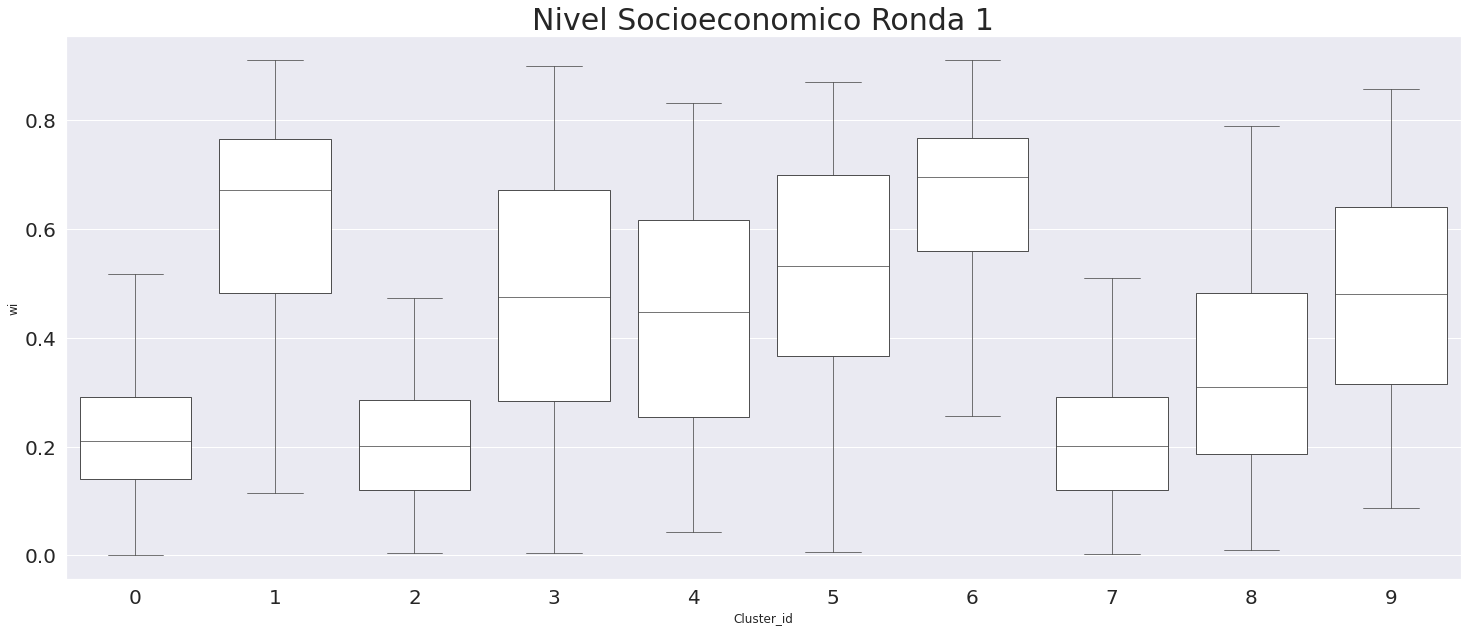

In [ ]:
sns.set(rc={'figure.figsize':(25,10)})
sequential_colors = sns.color_palette("Blues", 4)[1:]
variable = 'wi'
ax=sns.boxplot(data = data_long_clusters[(data_long_clusters[variable]>0)&(data_long_clusters.ronda==1)], x= 'Cluster_id', y=variable,showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("Nivel Socioeconomico Ronda 1",fontsize=30)

Text(0.5, 1.0, 'Indice de Masa Corporal Ronda 1')

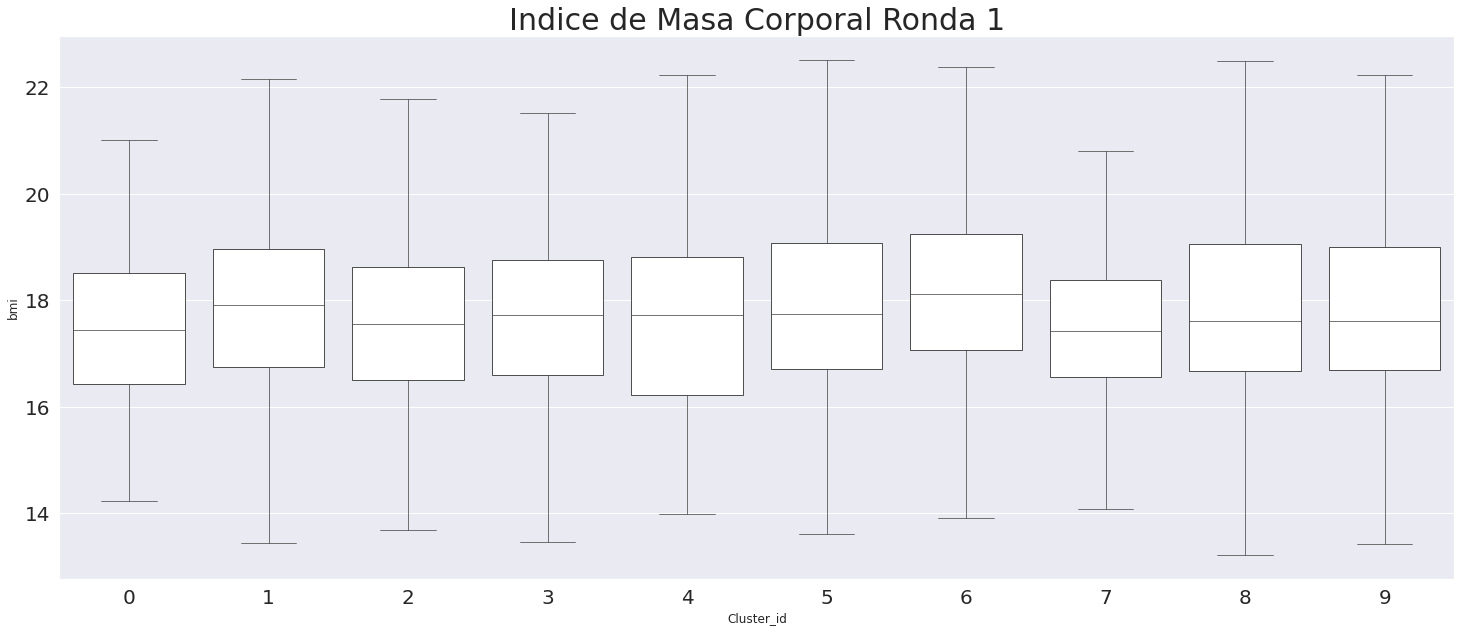

In [ ]:
sns.set(rc={'figure.figsize':(25,10)})
sequential_colors = sns.color_palette("Blues", 4)[1:]
variable = 'bmi'
ax=sns.boxplot(data = data_long_clusters[(data_long_clusters[variable]>0)&(data_long_clusters.ronda==1)], x= 'Cluster_id', y=variable,showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("Indice de Masa Corporal Ronda 1",fontsize=30)

Text(0.5, 1.0, 'Retraso en el crecimiento - Ronda 1')

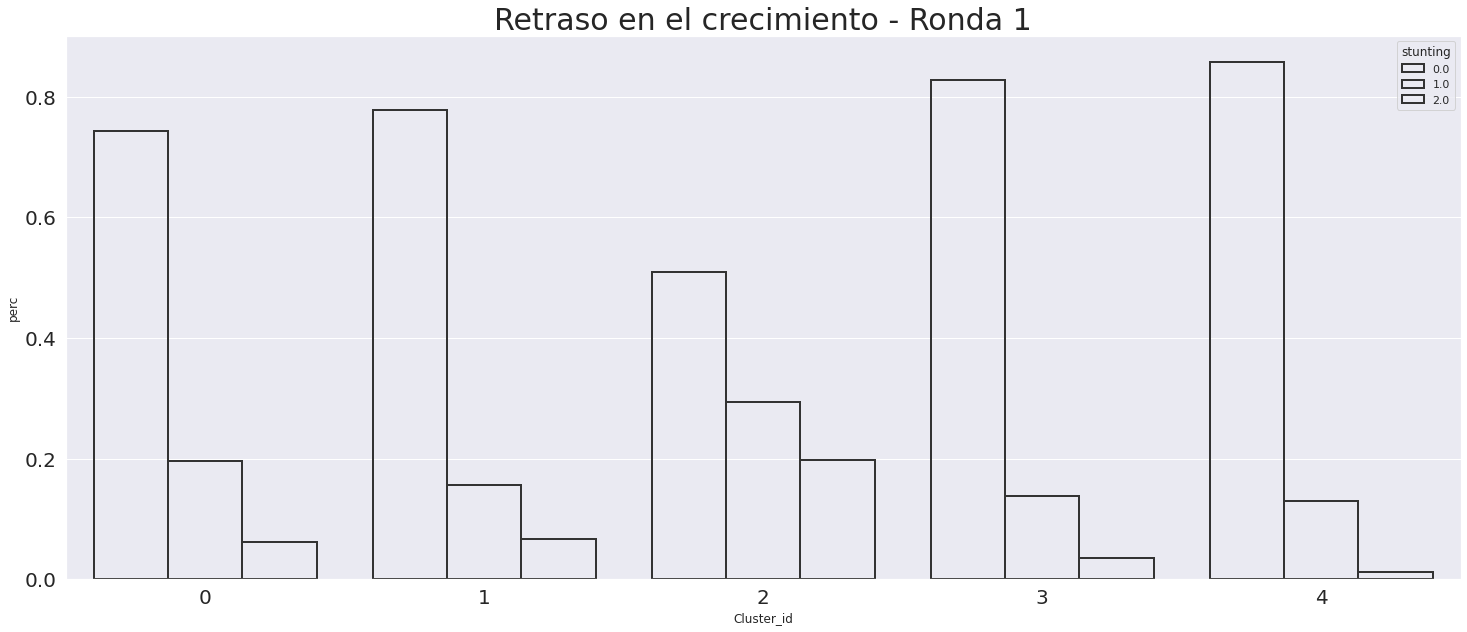

In [ ]:
crosstab = data_long_clusters[data_long_clusters.ronda == 1].groupby(['Cluster_id'])['stunting'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="Cluster_id", hue="stunting",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Retraso en el crecimiento - Ronda 1", fontsize = 30)

Text(0.5, 1.0, 'Nacimiento en un Hospital - Ronda 1')

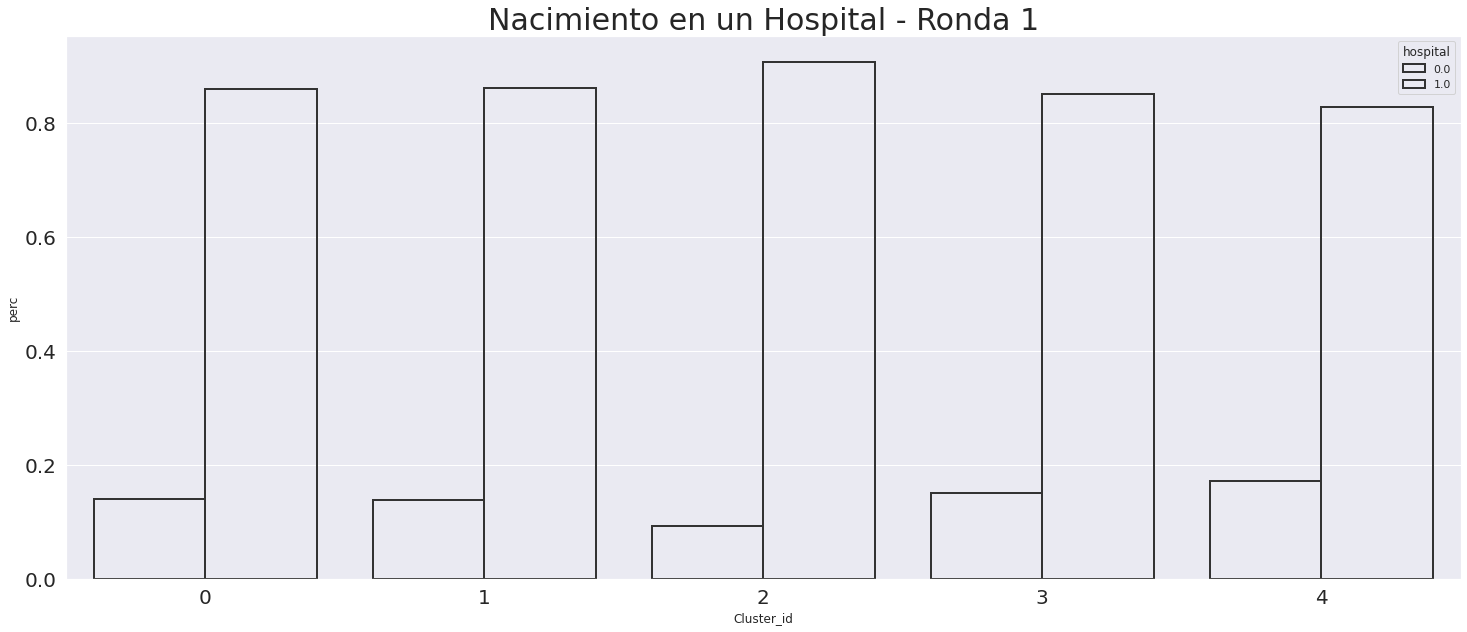

In [ ]:
crosstab = data_long_clusters[data_long_clusters.ronda == 1].groupby(['Cluster_id'])['hospital'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="Cluster_id", hue="hospital",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Nacimiento en un Hospital - Ronda 1", fontsize = 30)

Text(0.5, 1.0, 'Cantidad de Visitas Medicas Embarazo - Ronda 1')

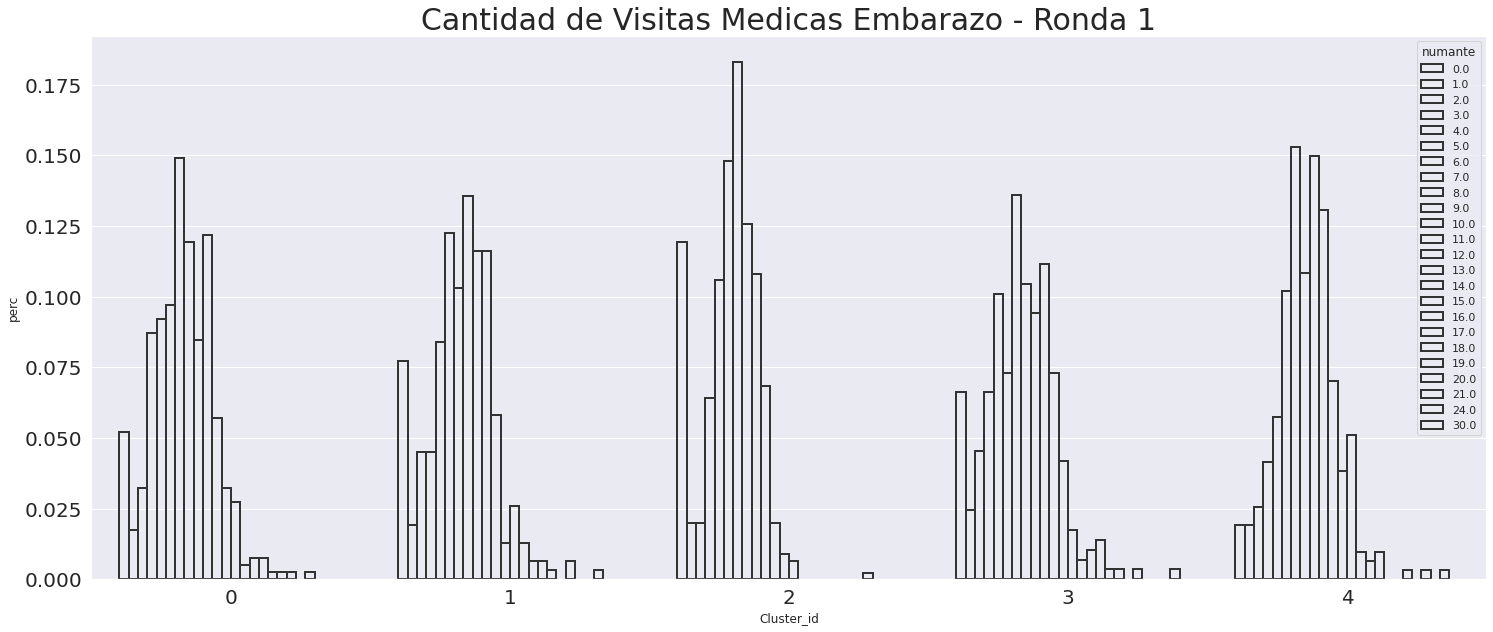

In [ ]:

crosstab = data_long_clusters[data_long_clusters.ronda == 1].groupby(['Cluster_id'])['numante'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="Cluster_id", hue="numante",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Cantidad de Visitas Medicas Embarazo - Ronda 1", fontsize = 30)

In [ ]:
data_long_clusters[data_long_clusters.ronda == 1].groupby('Cluster_id').agg({
    "childid":['count'],
    "bmi":['mean'],
    "stunting":['mean'],
    'hospital':['mean'],
    'delivery':['mean'],
    'chhrel':['mean'],
    'bwght':['mean'],
    'bwdoc':['mean'],
    'numante':['mean'],
})

,childid,bmi,stunting,hospital,delivery,chhrel,bwght,bwdoc,numante
,count,mean,mean,mean,mean,mean,mean,mean,mean
Cluster_id,,,,,,,,,
0,413,18.005,0.318,0.860,0.828,1.625,3203.136,0.633,6.415
1,317,17.764,0.289,0.861,0.775,1.676,3226.070,0.635,6.358
2,461,17.586,0.689,0.907,0.474,1.808,3063.623,0.562,5.296
3,292,18.056,0.208,0.849,0.876,1.599,3239.970,0.733,6.519
4,324,17.960,0.154,0.827,0.950,1.587,3291.114,0.748,7.268


In [ ]:
data_long_clusters[data_long_clusters.ronda == 1].groupby('Cluster_id').agg({
    'wi':['mean'],
    'hq':['mean'],
    'sv':['mean'],
    'cd':['mean']
})

,wi,hq,sv,cd
,mean,mean,mean,mean
Cluster_id,,,,
0,0.434,0.410,0.624,0.266
1,0.437,0.414,0.619,0.278
2,0.212,0.240,0.290,0.110
3,0.539,0.501,0.780,0.334
4,0.614,0.556,0.827,0.457


## Ronda 3

In [ ]:
data_long_clusters[(data_long_clusters.ronda == 3)|(data_long_clusters.ronda == 1)].groupby(['Cluster_id','ronda']).agg({
    "childid":['count'],
    'wi':['mean'],
    "bmi":['mean'],
    "stunting":['mean'],
    'chhrel':['mean'],
    'enrol':['mean'],
    'entype':['mean'],
    'levlwrit':['mean'],
    'levlread':['mean'],
    'ppvt_raw':['mean'], 
    'maths_raw':['mean'],
    'juntos':['mean'],
    'sisgrat_yl':['mean'],
    'credit':['mean']

 
})

childid    wi    bmi stunting chhrel enrol entype levlwrit  \
                   count  mean   mean     mean   mean  mean   mean     mean   
Cluster_id ronda                                                              
0          1         109 0.236 17.616    0.870  1.869 0.000  2.000      NaN   
           3         109 0.352 16.421    0.578  1.560 0.963  2.000    2.142   
1          1         284 0.617 17.970    0.158  1.617 0.000  1.900      NaN   
           3         284 0.707 17.519    0.095  1.691 0.993  1.784    2.797   
2          1         185 0.212 17.659    0.650  1.786 0.000  2.000      NaN   
           3         185 0.345 16.035    0.462  1.486 1.000  2.000    1.973   
3          1         230 0.470 17.807    0.275  1.668 0.000  1.909      NaN   
           3         230 0.601 17.061    0.178  1.587 1.000  1.883    2.691   
4          1         132 0.442 17.592    0.260  1.628 0.000  1.667      NaN   
           3         132 0.556 16.834    0.182  1.674 0.985  1.916    2.485   
5          1         183 0.511 18.154    0.273  1.607 0.000  2.000      NaN   
           3         183 0.626 16.998    0.159  1.615 0.962  1.820    2.542   
6          1         122 0.644 18.201    0.131  1.467 0.000  2.000      NaN   
           3         122 0.718 17.988    0.057  1.661 1.000  1.721    2.803   
7          1         203 0.221 17.575    0.562  1.775 0.000  2.000      NaN   
           3         203 0.349 16.052    0.396  1.517 0.990  1.990    2.652   
8          1         171 0.345 18.006    0.398  1.655 0.000  2.000      NaN   
           3         171 0.494 16.603    0.228  1.556 1.000  1.971    2.494   
9          1         188 0.474 17.915    0.242  1.643 0.000  2.000      NaN   
           3         188 0.587 17.014    0.213  1.564 0.995  1.898    2.590   

                 levlread ppvt_raw maths_raw juntos sisgrat_yl credit  
                     mean     mean      mean   mean       mean   mean  
Cluster_id ronda                                                       
0          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.170   47.566    11.077  0.743      0.954  0.110  
1          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.897   70.094    17.172  0.007      0.251  0.405  
2          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.038   40.859     9.448  0.584      0.919  0.097  
3          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.883   65.960    16.083  0.070      0.590  0.357  
4          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.621   60.943    14.468  0.068      0.664  0.205  
5          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.665   60.746    14.376  0.038      0.566  0.308  
6          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.910   72.568    17.880  0.000      0.256  0.405  
7          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.741   48.309    11.646  0.337      0.916  0.099  
8          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.675   55.744    13.440  0.129      0.778  0.269  
9          1          NaN      NaN       NaN    NaN        NaN    NaN  
           3        3.777   61.527    14.957  0.080      0.679  0.262

In [ ]:
data_long_clusters[data_long_clusters.ronda == 3].groupby('Cluster_id').agg({
    'wi':['mean'],
    'hq':['mean'],
    'sv':['mean'],
    'cd':['mean']
})

,wi,hq,sv,cd
,mean,mean,mean,mean
Cluster_id,,,,
0,0.352,0.265,0.596,0.194
1,0.707,0.577,0.923,0.622
2,0.345,0.256,0.569,0.210
3,0.601,0.481,0.836,0.486
4,0.556,0.433,0.811,0.425
5,0.626,0.510,0.871,0.497
6,0.718,0.595,0.961,0.598
7,0.349,0.273,0.546,0.228


In [ ]:
data_long_clusters[data_long_clusters.ronda == 3].groupby('Cluster_id').agg({
    'wi':['mean'],
    'hq':['mean'],
    'sv':['mean'],
    'cd':['mean']
})

In [ ]:


data_long_clusters[data_long_clusters.ronda == 3].groupby('Cluster_id').agg({
    'preprim':['mean'],
    'enrol':['mean'],
    'entype':['mean'],
    'literate':['mean'],
    'engrade':['mean'],
    'levlwrit':['mean'],
    'levlread':['mean'],
    'hschool':['mean'],
    'hstudy':['mean'],
    'commsch':['mean'],
    'agegr1':['mean'],
    'timesch':['mean']
})

,preprim,enrol,entype,literate,engrade,levlwrit,levlread,hschool,hstudy,commsch,agegr1,timesch
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Cluster_id,,,,,,,,,,,,
0,0.954,0.963,2.000,0.377,2.055,2.142,3.170,5.771,1.459,NaN,5.815,21.267
1,0.986,0.993,1.784,0.815,2.415,2.797,3.897,6.095,2.057,NaN,5.583,12.272
2,0.849,1.000,2.000,0.290,2.081,1.973,3.038,6.081,1.595,NaN,5.802,17.281
3,0.961,1.000,1.883,0.704,2.404,2.691,3.883,5.900,1.970,NaN,5.616,12.454
4,0.909,0.985,1.916,0.576,2.326,2.485,3.621,5.924,1.833,NaN,5.618,11.605
5,0.945,0.962,1.820,0.631,2.290,2.542,3.665,5.852,1.995,NaN,5.667,12.108
6,0.992,1.000,1.721,0.795,2.475,2.803,3.910,6.182,2.215,NaN,5.566,10.803
7,0.857,0.990,1.990,0.473,2.167,2.652,3.741,6.030,1.564,NaN,5.683,14.470


## Analisis Longitudinal: evolucion de variables para cada cluster a traves del tiempo

Text(0.5, 1.0, 'Nivel Socioeconomico por Ronda')

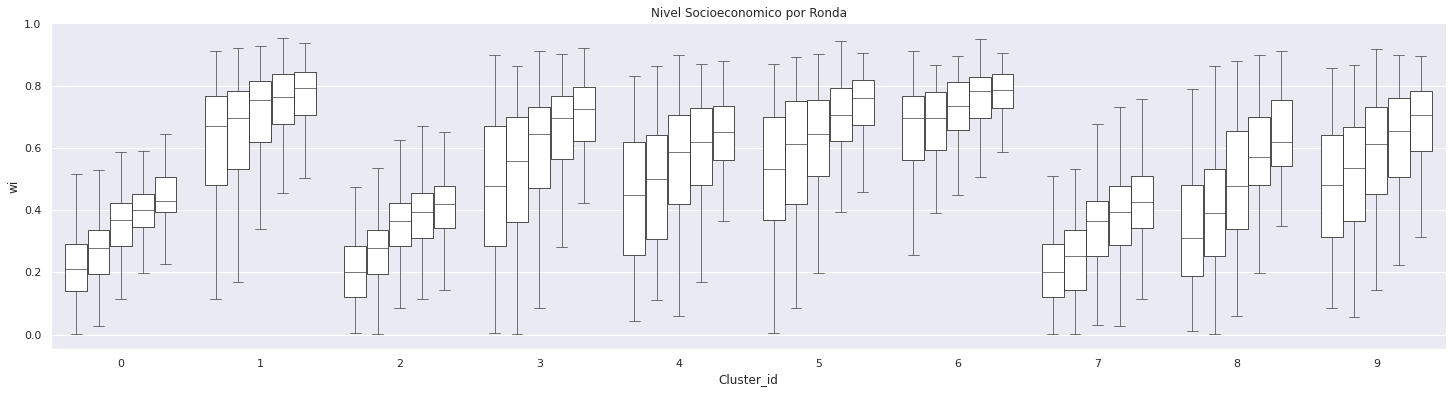

In [ ]:
sns.set(rc={'figure.figsize':(25,6)})
sequential_colors = sns.color_palette("Blues", 4)[1:]
variable = 'wi'
ax=sns.boxplot(data = data_long_clusters[data_long_clusters[variable]>0], x= 'Cluster_id', y=variable, hue='ronda',showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("Nivel Socioeconomico por Ronda")

Text(0.5, 1.0, 'Indice de Masa Corporal por Ronda')

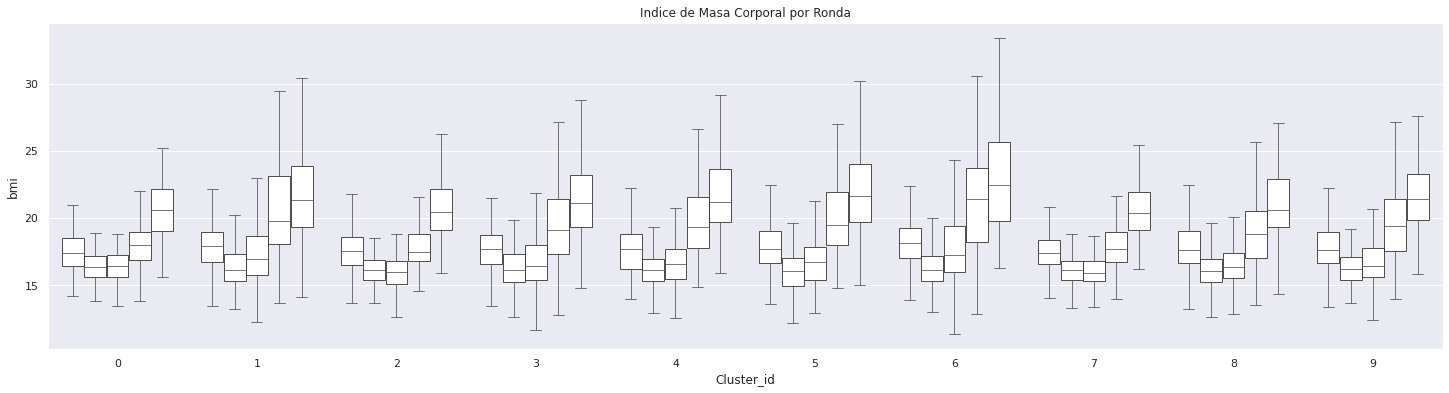

In [ ]:
variable = 'bmi'
ax=sns.boxplot(data = data_long_clusters[data_long_clusters[variable]>0], x= 'Cluster_id', y=variable, hue='ronda',showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("Indice de Masa Corporal por Ronda")

Text(0.5, 1.0, 'Indice de Calidad de Vivienda por Round')

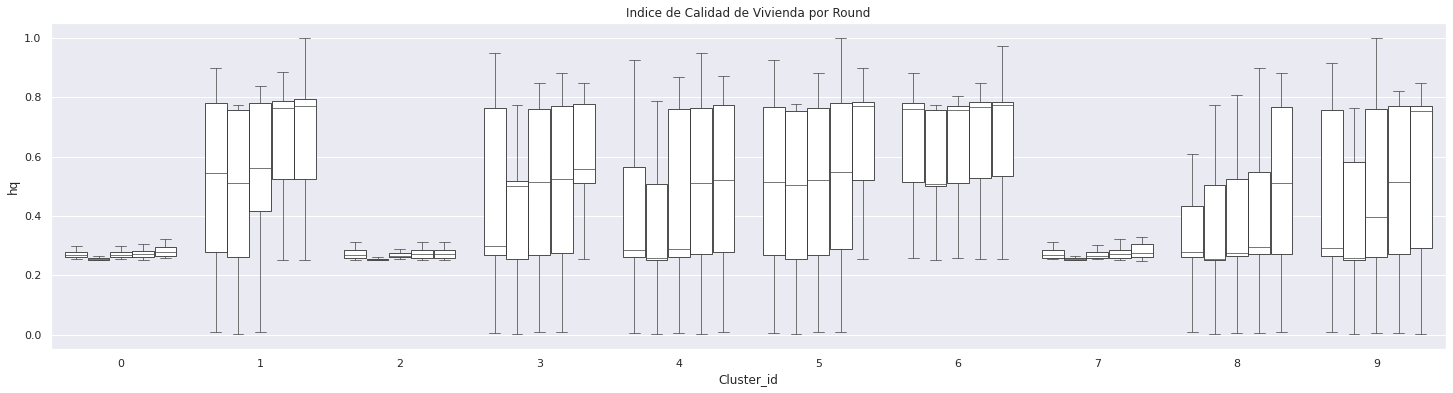

In [ ]:
variable = 'hq'
ax=sns.boxplot(data = data_long_clusters[data_long_clusters[variable]>0], x= 'Cluster_id', y=variable, hue='ronda',showfliers=False,linewidth=0.75)
plt.legend([],[], frameon=False)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w');
plt.title("Indice de Calidad de Vivienda por Round")

Text(0.5, 1.0, 'juntos')

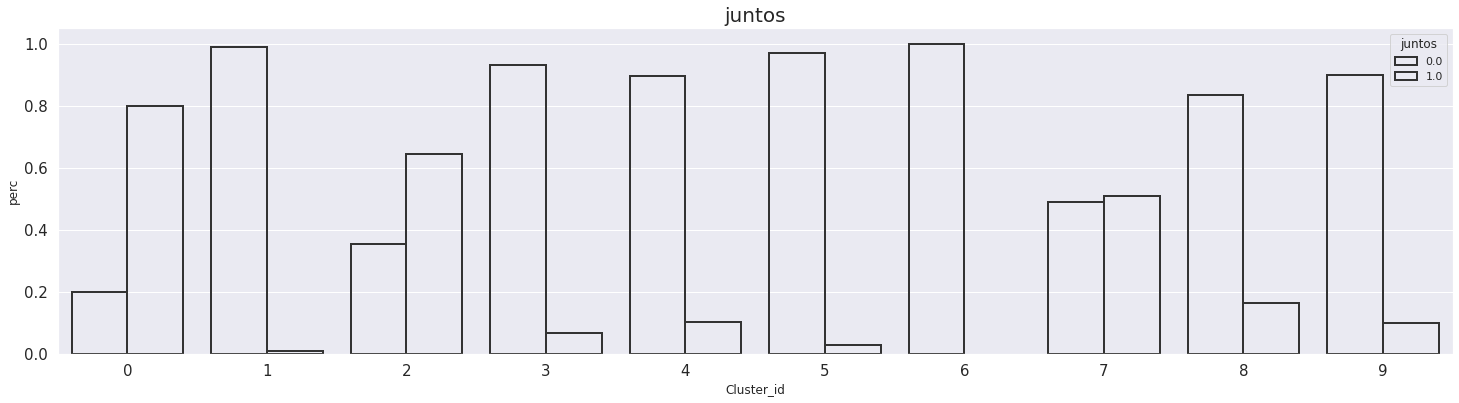

In [ ]:

crosstab = data_long_clusters.groupby(['Cluster_id'])['juntos'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="Cluster_id", hue="juntos",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Plan Juntos en Alguna de las rondas", fontsize = 20)

Text(0.5, 1.0, 'juntos')

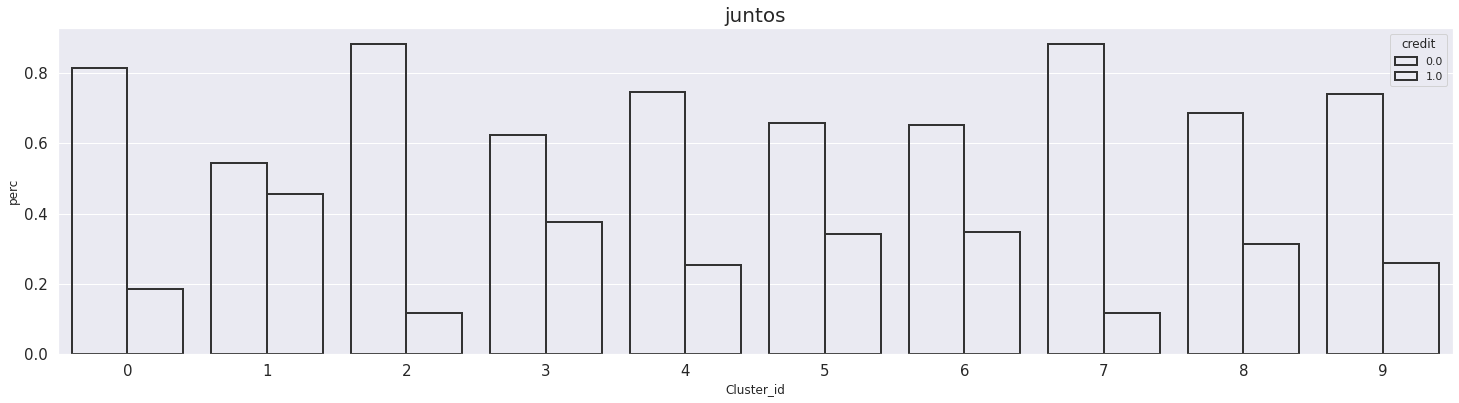

In [ ]:
crosstab = data_long_clusters.groupby(['Cluster_id'])['credit'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="Cluster_id", hue="credit",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("juntos", fontsize = 20)

Text(0.5, 1.0, 'stunting')

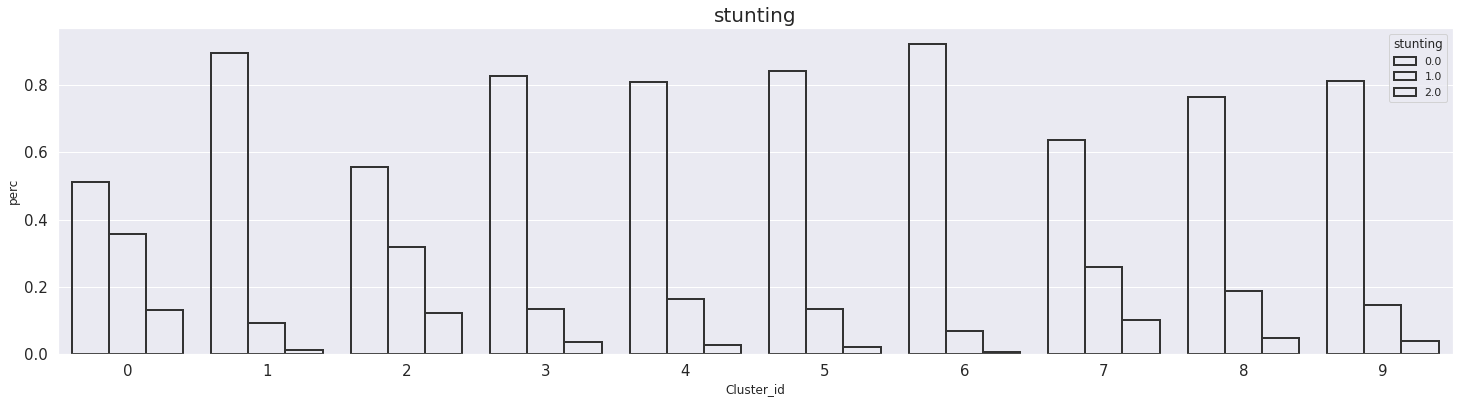

In [ ]:
crosstab = data_long_clusters.groupby(['Cluster_id'])['stunting'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="Cluster_id", hue="stunting",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("stunting", fontsize = 20)

Text(0.5, 1.0, 'levlwrit')

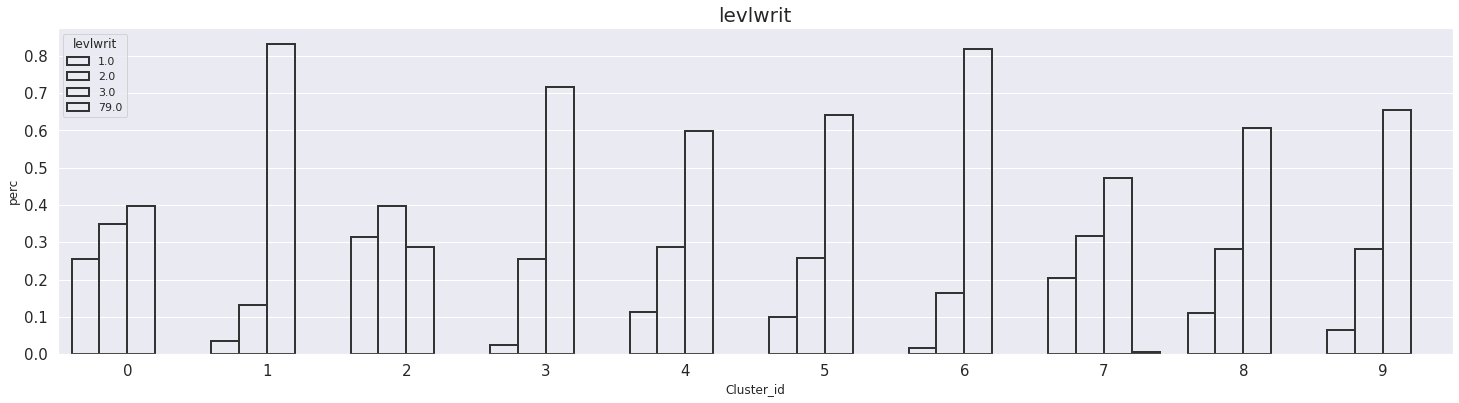

In [ ]:
crosstab = data_long_clusters.groupby(['Cluster_id'])['levlwrit'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="Cluster_id", hue="levlwrit",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("levlwrit", fontsize = 20)

Text(0.5, 1.0, 'literate')

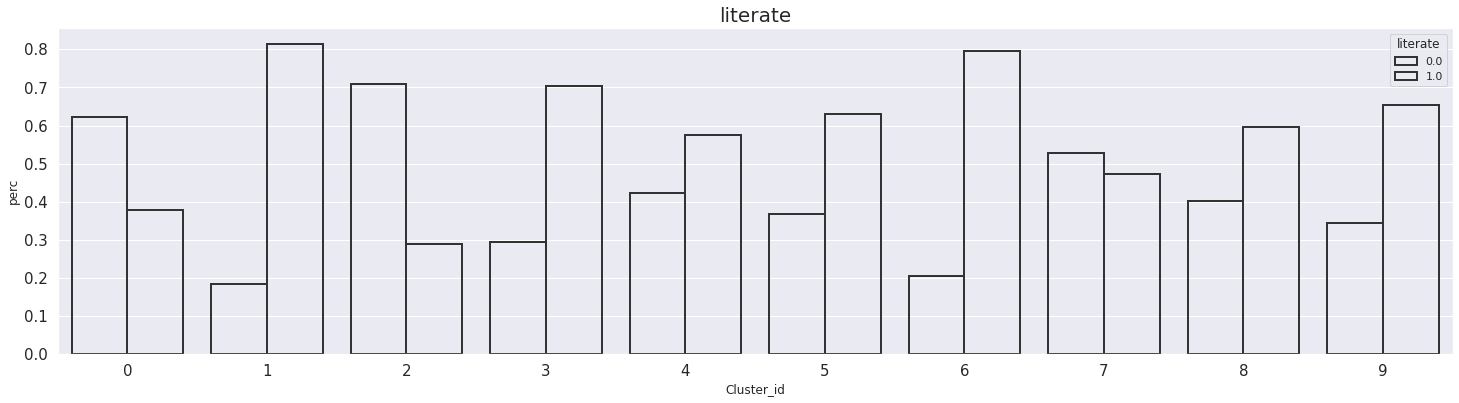

In [ ]:
crosstab = data_long_clusters.groupby(['Cluster_id'])['literate'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="Cluster_id", hue="literate",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("literate", fontsize = 20)

Text(0.5, 1.0, 'aniany')

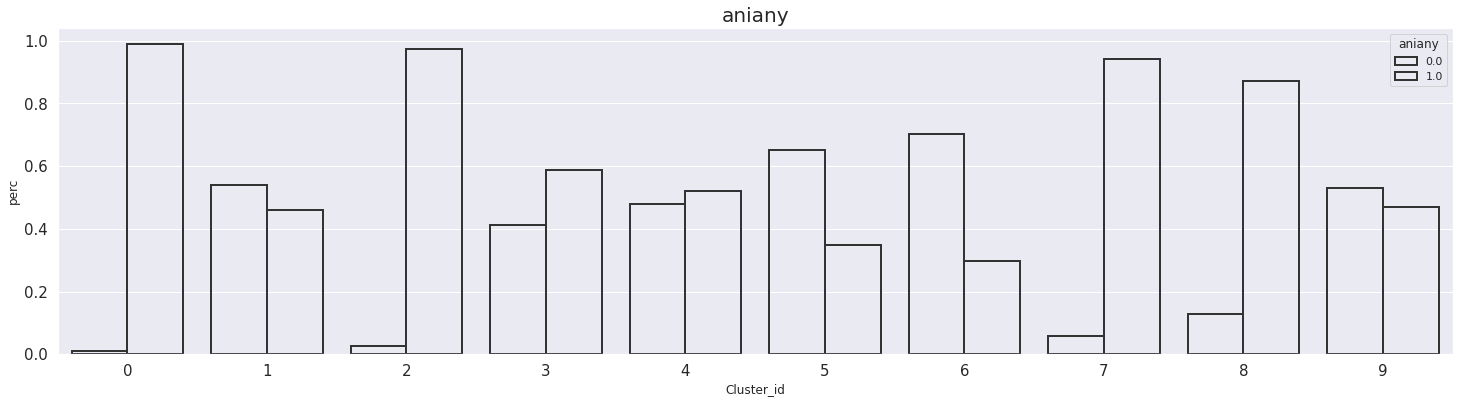

In [ ]:
crosstab = data_long_clusters.groupby(['Cluster_id'])['aniany'].value_counts(normalize=True)
crosstab = pd.Series(crosstab,name= 'perc').reset_index()
ax = sns.barplot(x="Cluster_id", hue="aniany",y='perc', data=crosstab, linewidth=2, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("aniany", fontsize = 20)